In [1]:
# Importing some packages
import os
os.chdir("/Users/ieo5776/Desktop/Garmin_analysis/")

import sys
from typing import Any, Dict, List, Union
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import garth
from garth.exc import GarthException
import seaborn as sns
from scipy import stats

# custom functions
from utils import sleep_functions

# To Do List

1) General analysis on sleep data.
2) focus on an average month vs August for sleep quality
3) Predict sleep score based on the individual scores of each night, i don't think they do it like that but let's see

In [2]:
# Check if connection is still valid, otherwise ask for credentials
GARTH_HOME = "/Users/ieo5776/Desktop/Garmin_analysis"

from garth.exc import GarthException
from getpass import getpass

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (GarthException, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

#garth.resume("~/.garth")

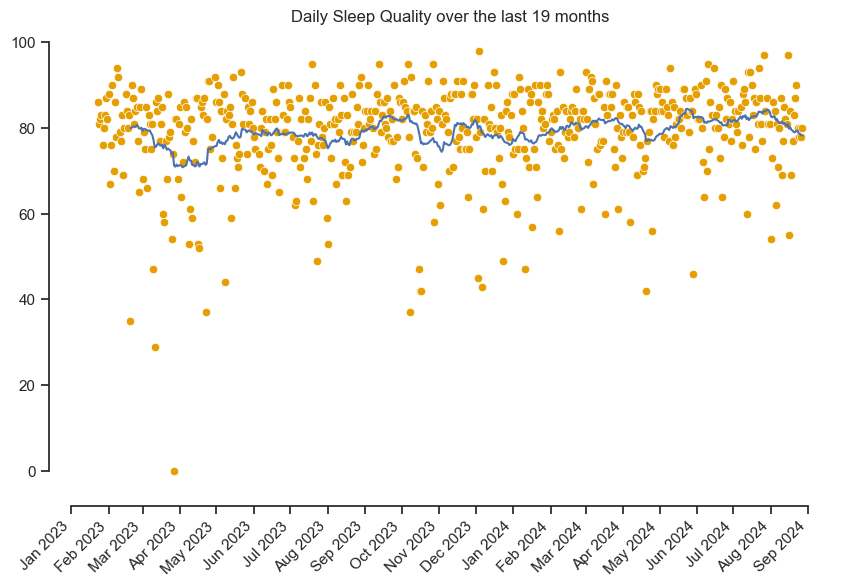

In [4]:
# retrive sleep data
daily_sleep = pd.DataFrame(garth.DailySleep.list(period=365*2))

daily_sleep["calendar_date"] = pd.to_datetime(daily_sleep["calendar_date"])
daily_sleep.set_index("calendar_date", inplace=True)
daily_sleep['rolling_average'] = daily_sleep['value'].rolling(window=28).mean()
daily_sleep

# Plot full sleep data
sleep_functions.plt_sleep(daily_sleep, colors=["#E69F00"])
#sns.lineplot(data=daily_sleep.roll, legend=False, palette=["#56B4E9"])

In [4]:
# Gather daily sleep data to find bedtime and wake up time
latest = garth.DailySleep.list(period=2)[-1].calendar_date
#sleep_data = [sd.daily_sleep_dto for sd in garth.SleepData.list(latest, 365+(int(365/2)))]
sleep_data = [sd.daily_sleep_dto for sd in garth.SleepData.list(latest, int(365/2))]

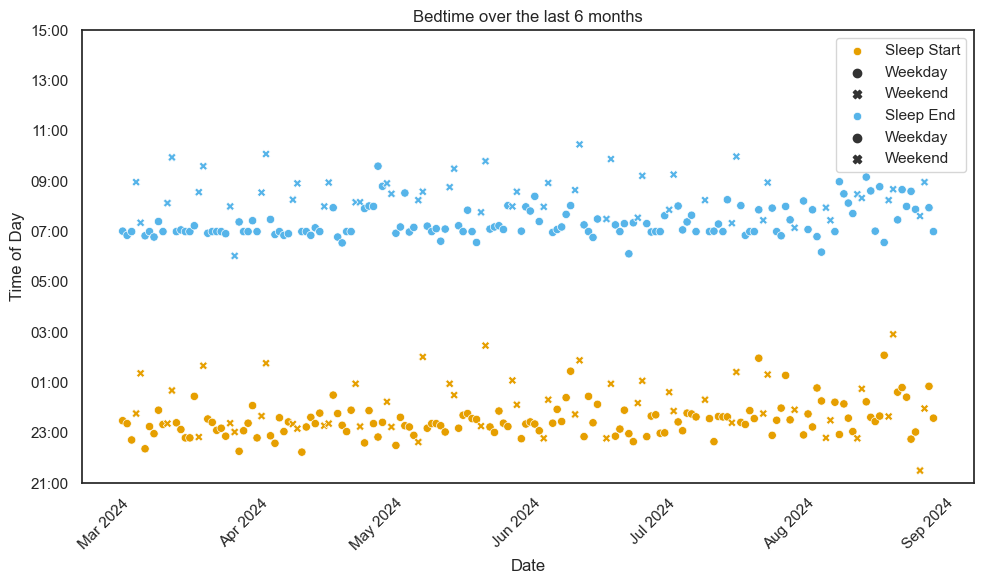

In [7]:
df = pd.DataFrame(sleep_data)
df.sort_values("calendar_date", inplace=True)
df.set_index("calendar_date", inplace=True)
df["weekdays"] = pd.to_datetime(df.index).day_name().values
df['day_type'] = df["weekdays"].apply(sleep_functions.is_weekend)

# Convert to datatime
df.index = pd.to_datetime(df.index)

# There's time stamps provided but are in milliseconds
start_col = "sleep_start_timestamp_local"
end_col = "sleep_end_timestamp_local"

# Convert to hours and minutes
df["sleep_start"] = pd.to_datetime(df[start_col], unit="ms").dt.time
df["sleep_end"] = pd.to_datetime(df[end_col], unit="ms").dt.time

# Convert to allow 21:00 as the starting point
df["sleep_start_hours"] = df["sleep_start"].apply(sleep_functions.convert_time)
df["sleep_end_hours"] = df["sleep_end"].apply(sleep_functions.convert_time)

# Plot bedtime
sleep_functions.plot_bedtime(df, title="Bedtime over the last 6 months")


In [6]:
#garth.connectapi("/userprofile-service/userprofile/user-settings")
#garth.UserSettings.get()
#garth.connectapi("/userprofile-service/socialProfile")
#camel_to_snake_dict(garth.connectapi("/userprofile-service/userprofile/user-settings"))